Using device: cuda


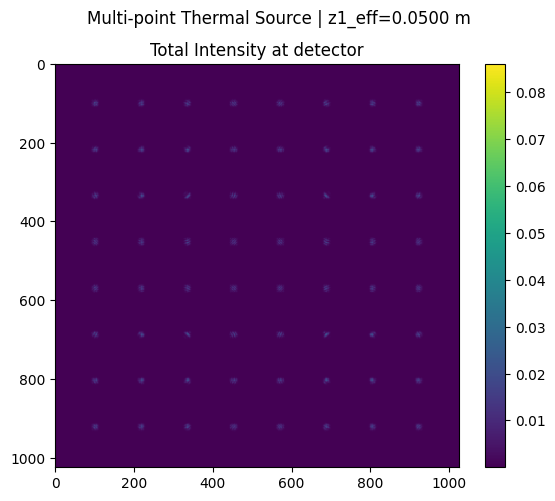

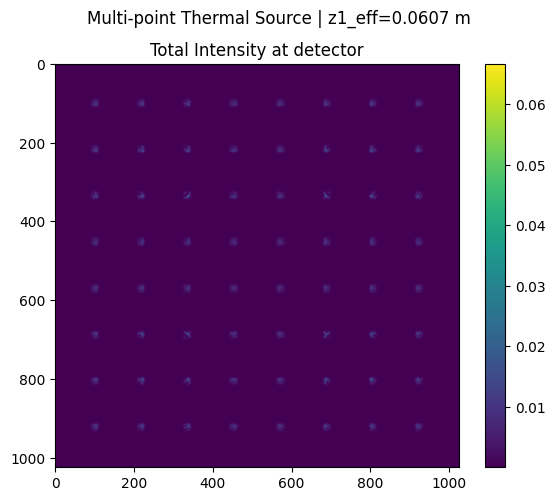

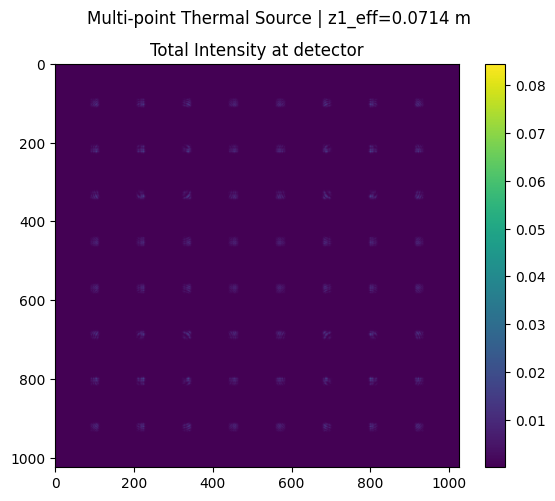

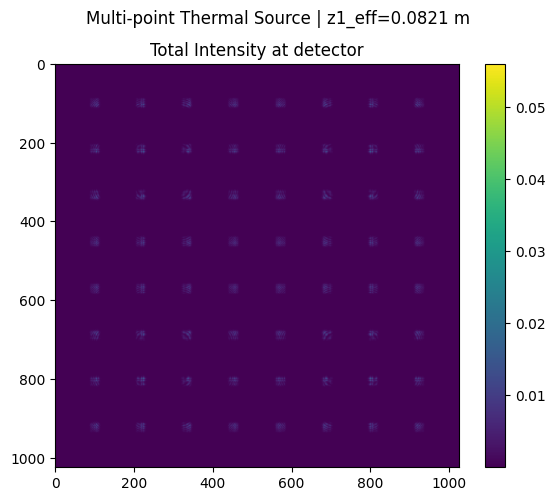

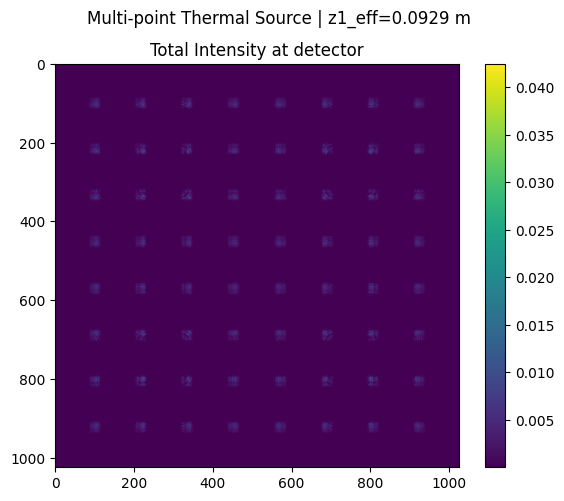

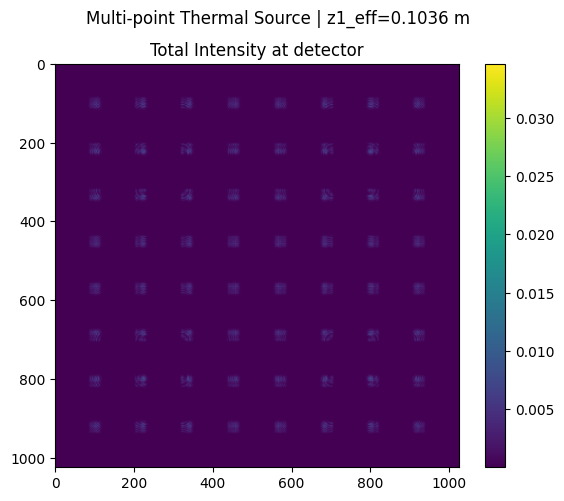

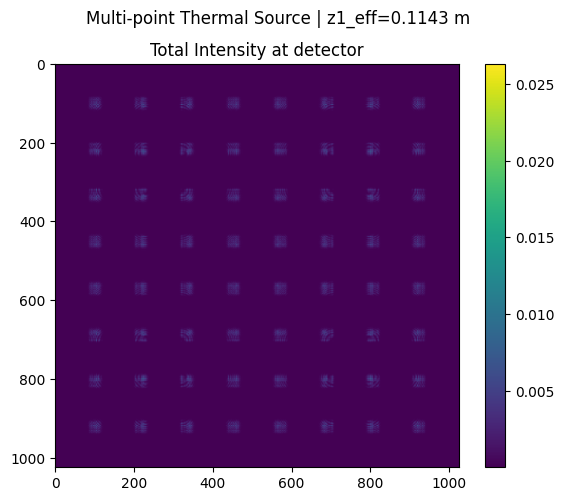

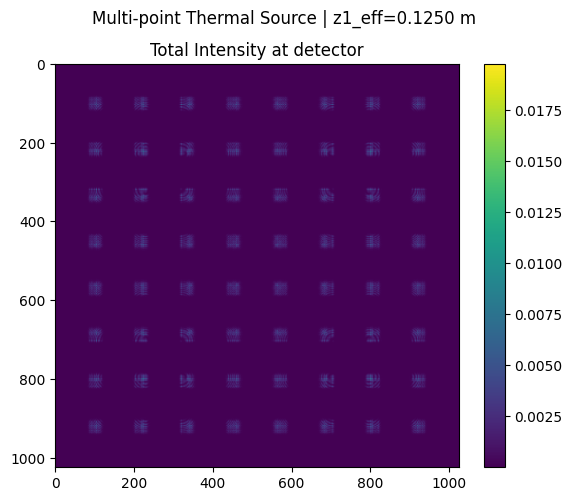

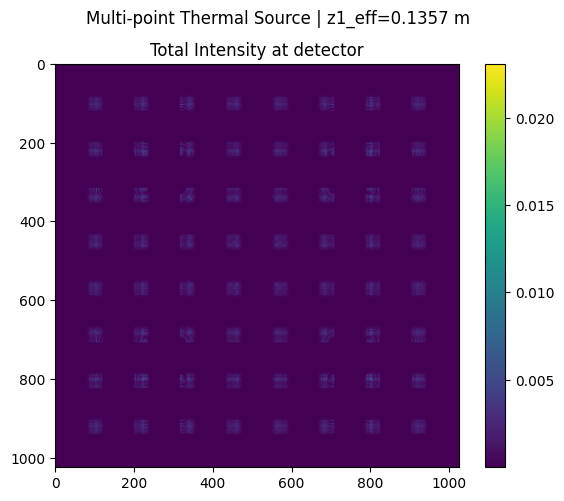

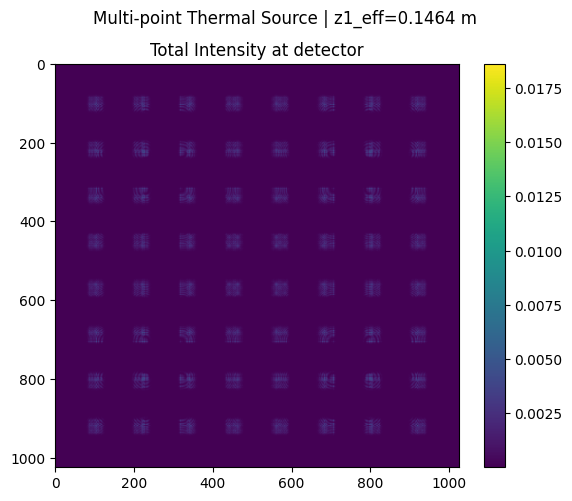

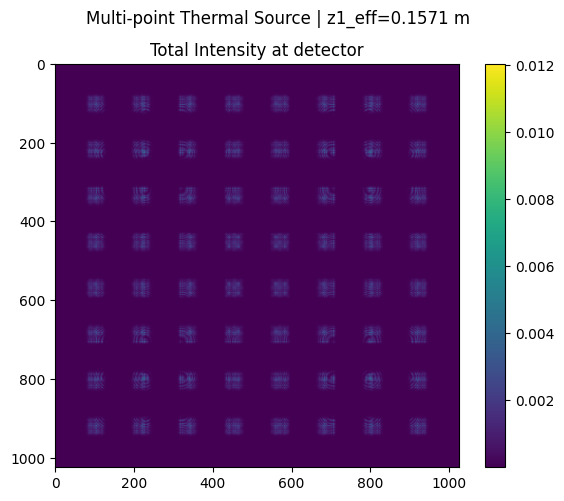

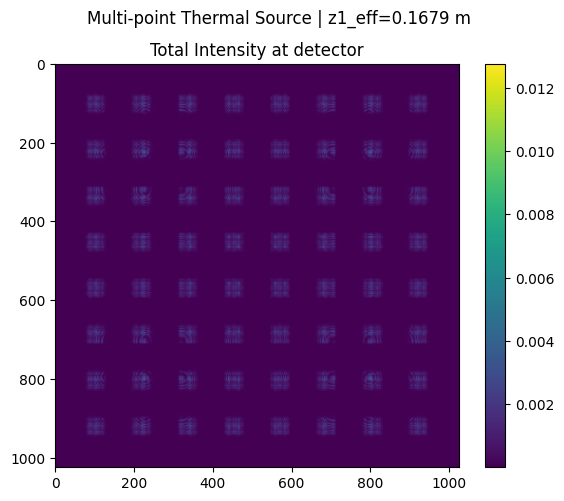

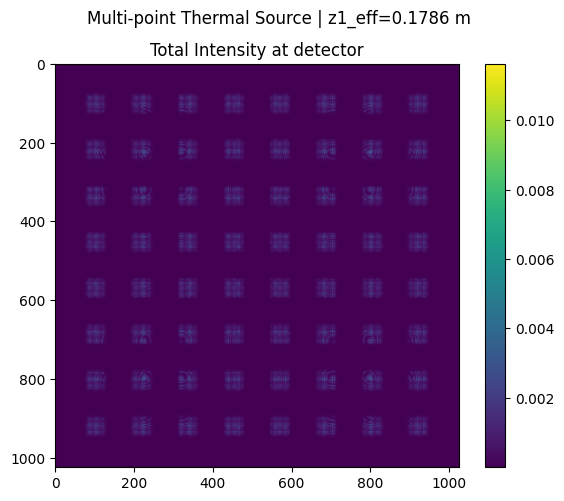

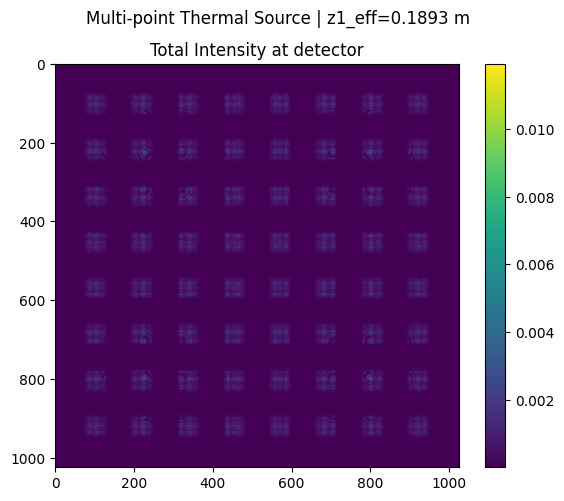

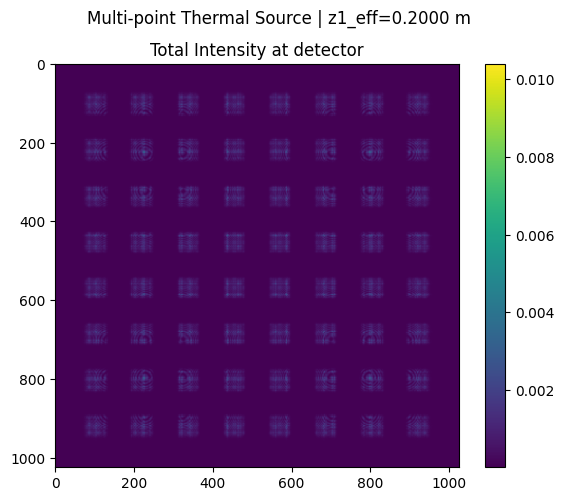

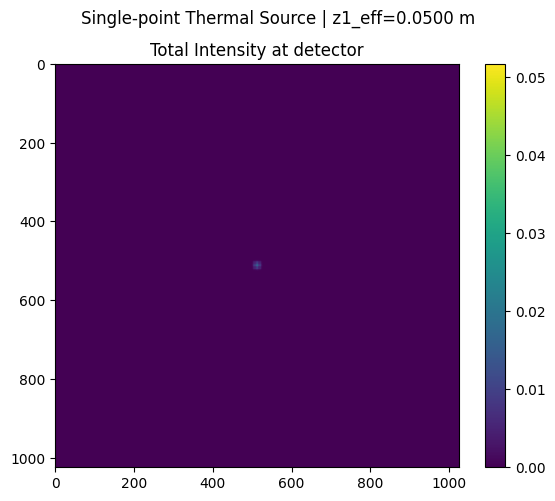

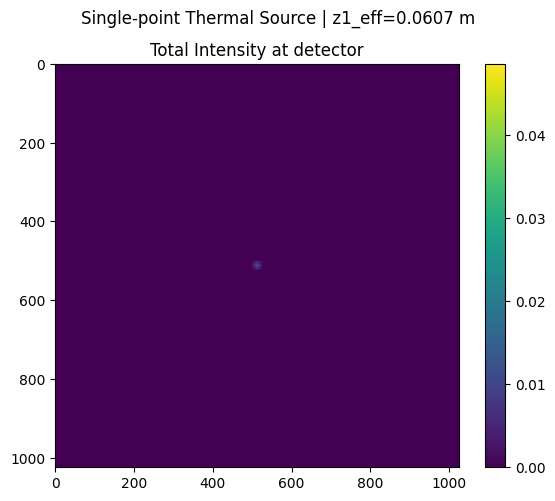

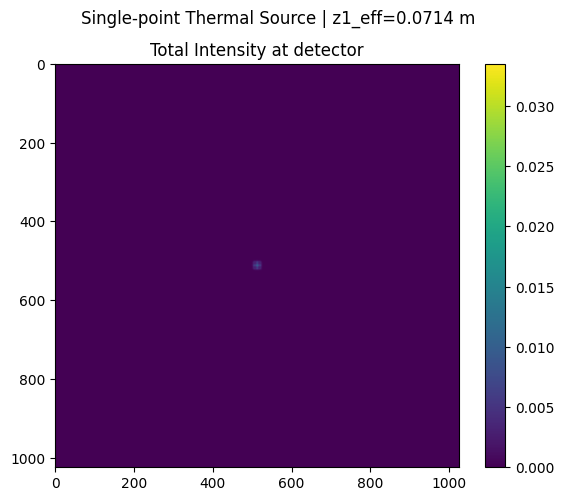

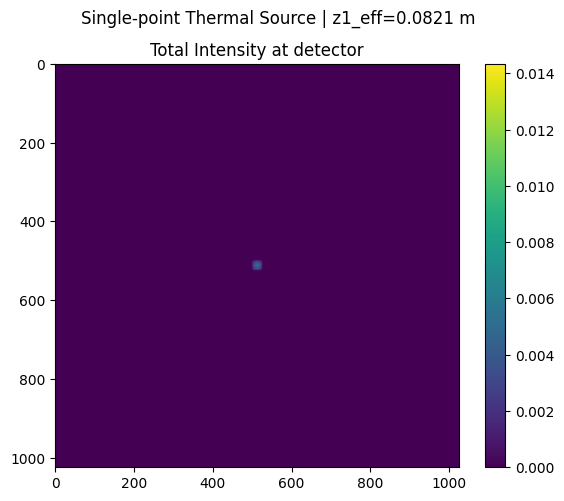

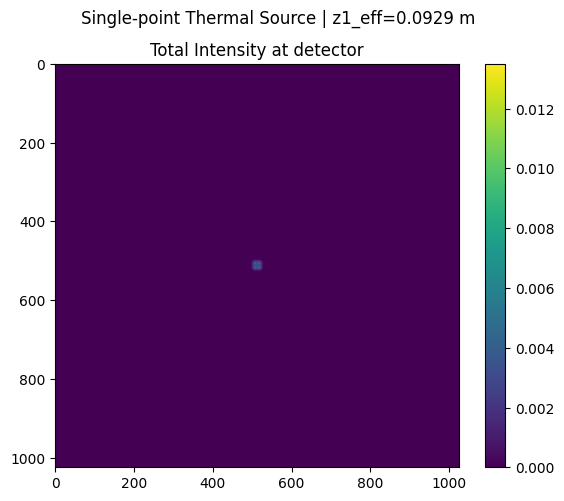

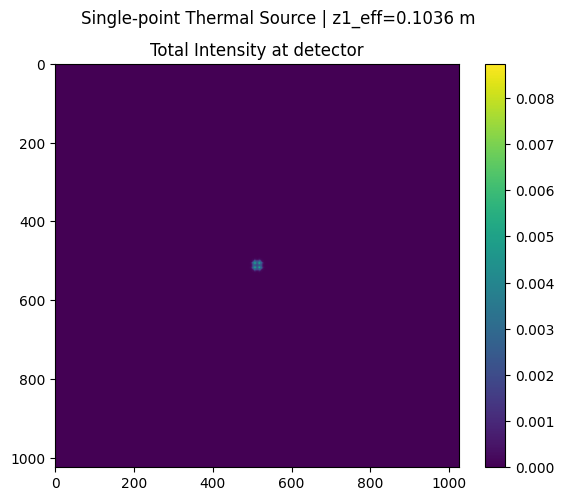

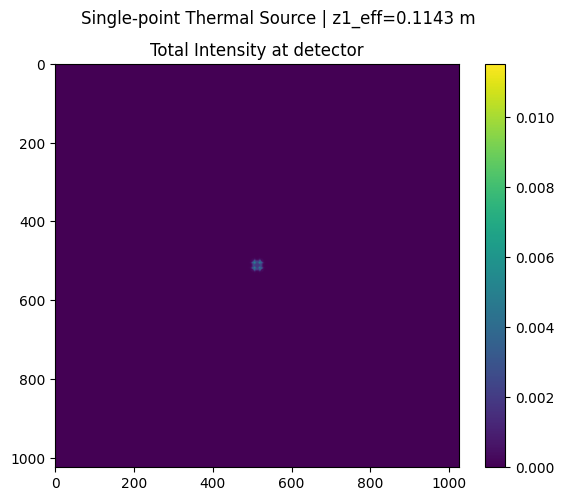

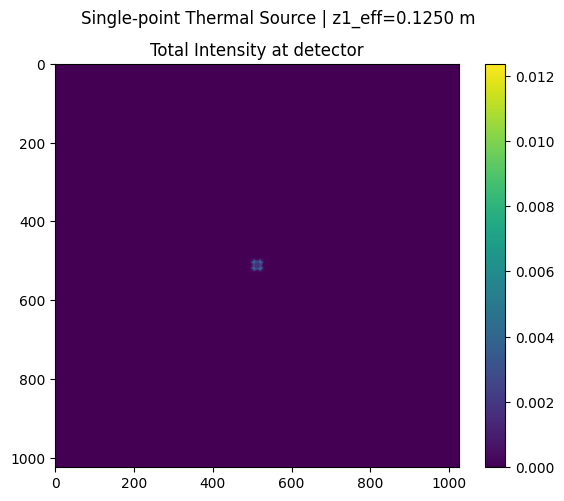

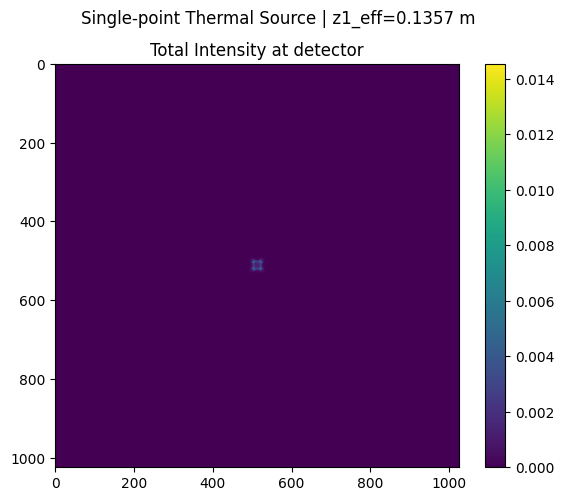

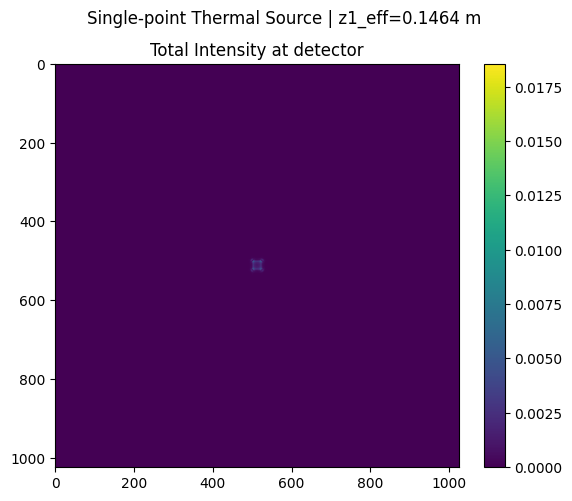

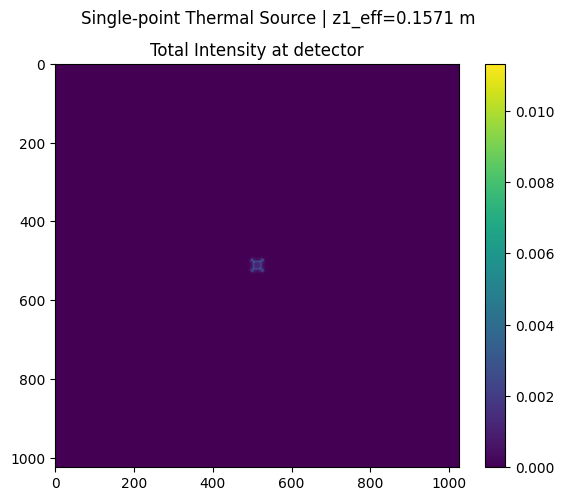

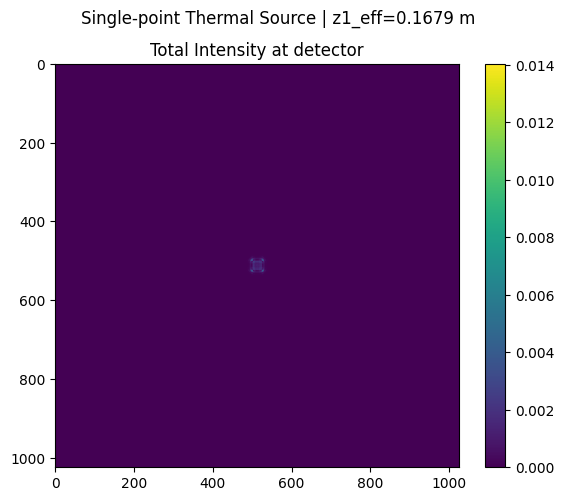

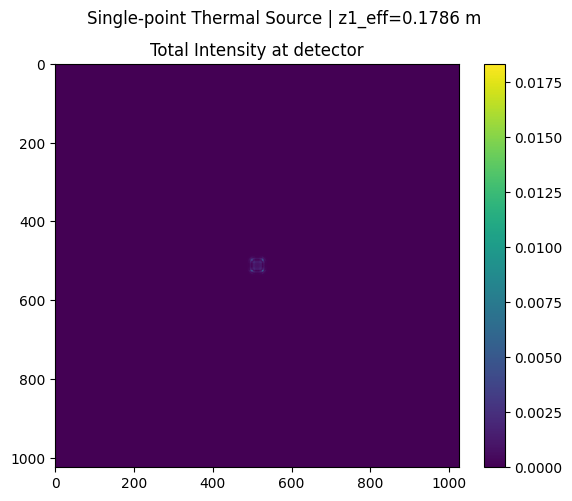

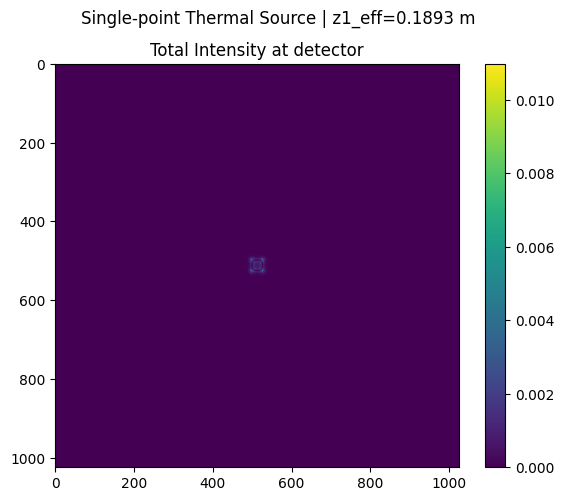

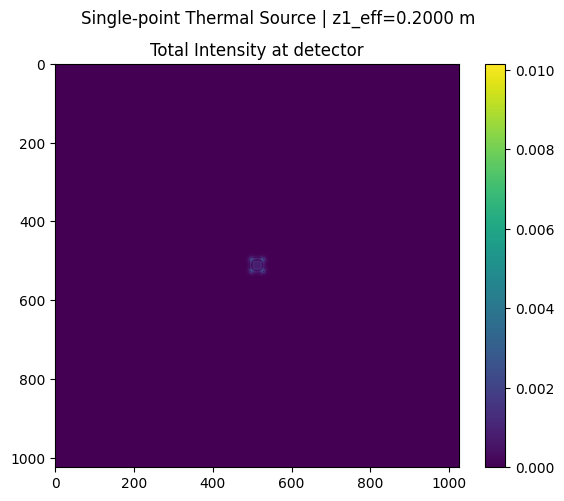

끝.


In [12]:
import torch
import matplotlib.pyplot as plt
from torchOptics.optics import Tensor, propASM, applylens
import numpy as np

# === [실험 조건] ===
wavelength = 632.8e-9  # m (예시: HeNe 레이저)
grid_size = 1024
dx = 50e-6  # m
f_plus = 0.15
f_minus = 0.25
meta = {'dx': (dx, dx), 'wl': (wavelength,)}

# === [GPU 설정] ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 시뮬레이션할 광원 샘플 지점 정의 (두 가지 경우 모두 Thermal)
margin = int(0.1 * grid_size)

# 1. 여러 개의 샘플 포인트 (Thermal)
num_points_per_axis_multi = 8 # 예시로 축당 2x2=4점 사용
indices_multi = torch.linspace(margin, grid_size - margin - 1, num_points_per_axis_multi, dtype=torch.int32)
source_points_multi = [(int(x), int(y)) for x in indices_multi for y in indices_multi]

# 2. 가운데 한 점 (Thermal)
center_point = grid_size // 2
source_points_single = [(center_point, center_point)]

simulation_configs = [
    {'name': 'Multi-point Thermal Source', 'points': source_points_multi},
    {'name': 'Single-point Thermal Source', 'points': source_points_single}
]

z1_min = 0.05
z1_max = 0.20
num_z1_steps = 15
z1_values_to_simulate = torch.linspace(z1_min, z1_max, num_z1_steps)

z2_fixed = 0.05

# 좌표계 생성 for lens phase - GPU로 이동
x = torch.linspace(-grid_size//2, grid_size//2-1, grid_size) * dx
X, Y = torch.meshgrid(x, x, indexing='ij')
R2 = (X**2 + Y**2).to(device)

k = 2 * np.pi / wavelength

# 렌즈 위상 변환 항 계산
phase_term1 = torch.exp(1j * torch.tensor(k / (2 * f_plus), dtype=torch.complex64).to(device) * R2)
phase_term2 = torch.exp(1j * torch.tensor(k / (2 * f_minus), dtype=torch.complex64).to(device) * R2)
total_lens_phase_term = phase_term1 + phase_term2

# 각 시뮬레이션 설정 및 z1_eff 값에 대해 반복
for config in simulation_configs:
    sim_name = config['name']
    current_source_points = config['points']

    for z1_eff in z1_values_to_simulate:
        # 열광원 시뮬레이션 (비간섭성 합산을 위해 강도 맵 초기화)
        total_intensity_at_detector = torch.zeros((grid_size, grid_size), dtype=torch.float32, device=device)

        # 각 광원 샘플 지점에 대해 시뮬레이션
        for (x1, y1) in current_source_points:
            # 1. 광원의 특정 점(x1, y1)에서 나온 빛
            E0_template = torch.zeros((grid_size, grid_size), dtype=torch.complex64, device=device)
            E0_template[x1, y1] = 1.0 # 특정 점에서 발생한 광원 필드
            E0 = Tensor(E0_template, meta)

            # 2. 광학계 적용
            E1 = propASM(E0, float(z1_eff))
            E2 = E1 * total_lens_phase_term
            E3 = propASM(E2, float(z2_fixed))

            # 3. 비간섭성 합산을 위해 강도 계산 후 누적
            intensity_from_point = torch.abs(E3)**2
            total_intensity_at_detector += intensity_from_point.squeeze(0)

        # 4. 시각화
        plt.figure(figsize=(6, 5))
        plt.suptitle(f"{sim_name} | z1_eff={z1_eff:.4f} m")
        plt.imshow(total_intensity_at_detector.cpu().numpy(), cmap='viridis')
        plt.title('Total Intensity at detector')
        plt.colorbar()
        plt.tight_layout()
        plt.show()

print("끝.")